# AIPI 590 - XAI | Assignment #5

### Osama Ahmed


![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=green)
[![View notebooks on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/osama-shawir/Interpretable-ML-Models-II/blob/main/interpretable%20ml%20II.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/osama-shawir/Interpretable-ML-Models-II/blob/main/interpretable%20ml%20II.ipynb)  

This project involves generating explanations for a machine learning model using LIME Image Explainer. The model used is resnet34 pre-trained on the ImageNet dataset. The image we use for the explanation is a picture of a tigershark where we try to understand which parts of the image are important for the model's prediction.

### We start by installing and importing the necessary libraries

In [1]:
# !pip install torch==2.3 torchvision==0.18 numpy==2.0 lime
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader
import requests
from lime import lime_image
from skimage.segmentation import mark_boundaries

/home/codespace/.python/current/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### We then use the resnet34 model pre-trained on the ImageNet dataset to make predictions on the image of the tigershark to see if the model can correctly predict the image.

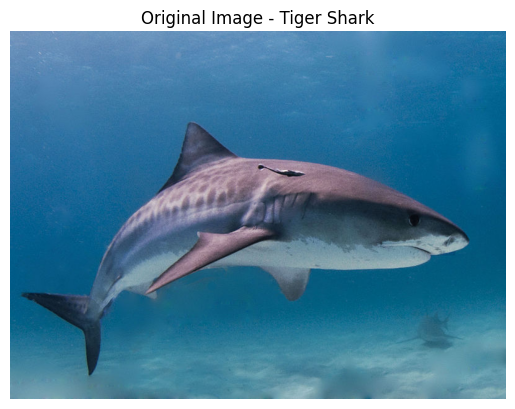

/home/codespace/.python/current/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Predicted class: tiger shark


In [2]:
# Load the image from the local file system
img_path = "tiger_shark.png"  # Local image path
img = Image.open(img_path)

# Display the original image
plt.imshow(img)
plt.title("Original Image - Tiger Shark")
plt.axis("off")
plt.show()

# Preprocess the image (resize to 224x224, normalize as required by ResNet)
preprocess = transforms.Compose(
    [
        transforms.Resize(256),  # Resize to 256 pixels for shortest side
        transforms.CenterCrop(224),  # Crop the center to 224x224
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),  # Normalize
    ]
)

# Apply preprocessing
input_tensor = preprocess(img)
input_batch = input_tensor.unsqueeze(0)  # Add batch dimension (required by PyTorch)

# Load pre-trained ResNet34 model
model = models.resnet34(pretrained=True)
model.eval()

# Make a prediction
with torch.no_grad():
    output = model(input_batch)
_, predicted = torch.max(output, 1)

# Download and load ImageNet class labels
labels_url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
response = requests.get(labels_url)
class_labels = response.json()

# Get the predicted class name
predicted_class_name = class_labels[predicted.item()]

# Print the predicted class name
print(f"Predicted class: {predicted_class_name}")

### Since the model correctly predicts the image, we then use the LIME Image Explainer to generate explanations for the model's prediction.

100%|██████████| 1000/1000 [01:32<00:00, 10.77it/s]


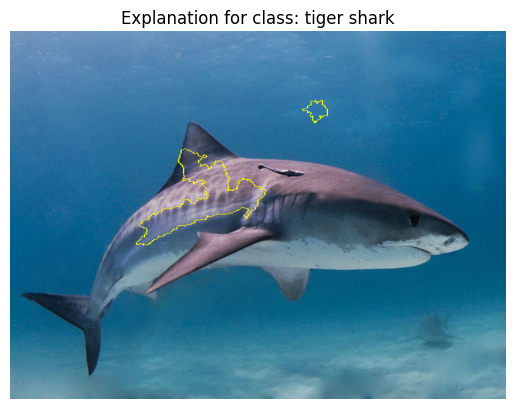

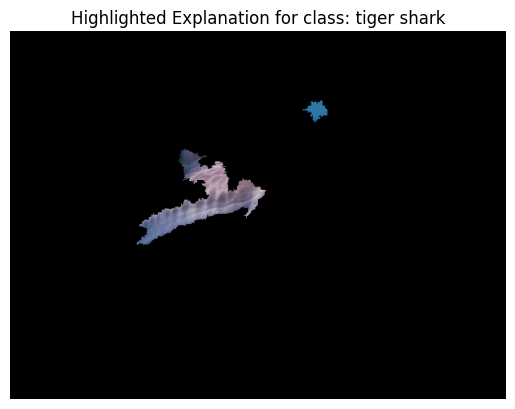

In [3]:
# Define a function to predict and preprocess the image
def predict(images):
    model.eval()
    # Preprocess the input images
    batch = torch.stack([preprocess(Image.fromarray(img)) for img in images])
    with torch.no_grad():
        outputs = model(batch)
    return torch.nn.functional.softmax(
        outputs, dim=1
    ).numpy()  # Use softmax to get probabilities


# Initialize LIME image explainer
explainer = lime_image.LimeImageExplainer()

# Explain the prediction on the uploaded image
explanation = explainer.explain_instance(
    np.array(img),  # Ensure img is a NumPy array
    predict,
    top_labels=5,
    hide_color=0,
    num_samples=1000,
)

# Get the explanation for the top predicted label
temp, mask = explanation.get_image_and_mask(
    predicted.item(), positive_only=True, num_features=5, hide_rest=False
)

# Plot the explanation
plt.imshow(mark_boundaries(temp / 255.0, mask))  # Normalize temp for plotting
plt.title(f"Explanation for class: {predicted_class_name}")
plt.axis("off")
plt.show()
plt.imsave("explanation.png", mark_boundaries(temp / 255.0, mask))

# Create a new image that only shows the parts inside the mask
highlighted_image = np.zeros_like(temp)
for i in range(3):  # Assuming the image has 3 color channels (RGB)
    highlighted_image[:, :, i] = temp[:, :, i] * mask

# Plot the highlighted explanation
plt.imshow(highlighted_image)
plt.title(f"Highlighted Explanation for class: {predicted_class_name}")
plt.axis("off")
plt.show()
plt.imsave("highlighted_explanation.png", highlighted_image)

## Explanation and Analysis of LIME Interpretation for "Tiger Shark" Classification

### 1. Explanation Image
![Explanation for class: tiger shark](masked_explanation.png)

- **Description**: The image above shows the original input (tiger shark) overlaid with yellow boundaries. These boundaries represent the regions of the image that contributed significantly to the model's prediction of the "tiger shark" class.
  
- **Key Observations**:
  - The yellow outlines indicate areas of interest that the model relies on to classify the image.
  - The highlighted regions primarily cover distinct features of the tiger shark, such as its body shape and fins, which are characteristic of this species.
  - It also appears that the model includes some background areas in its decision-making, which may suggest that the context or surroundings of the shark contribute to the classification.
  - For more clarity, we show only the highlighted regions in the next image to emphasize the specific features that influence the model's decision.

### 2. Highlighted Explanation Image
![Highlighted Explanation for class: tiger shark](highlighted_explanation.png)

- **Model Confidence**: The sparse areas that contribute to the model's prediction indicate that the model focuses on specific features rather than the entire image. We notice that these features are not unique to the tiger shark class, as they could be present in other marine animals as well, indicating the need for more distinctive features to improve classification accuracy in complex scenarios.

- **Interpretability**: These explanations provide insight into the model's reasoning, helping validate whether it focuses on the expected parts of the image (i.e., the tiger shark itself) or irrelevant background elements. The highlighted regions show that the model does a little bit of both, suggesting that it may benefit from more targeted training on relevant features.

- **Potential Issues**: 
  - Too few features are highlighted, indicating that the model may not be capturing the full range of characteristics that define a tiger shark.
  -  The model's reliance on background elements could lead to misclassification if similar features are present in other classes, highlighting the need for more robust feature selection.

### Conclusion
The LIME explanations effectively reveal how the ResNet34 model classifies a "tiger shark" by focusing on visual features from the shark itself and from the background. These insights help in understanding the model's decision-making process and assessing its reliability. Such explainability techniques can guide further model improvements and ensure that the classification is based on meaningful features rather than spurious correlations.